# Simple CTA Processing Pipeline

Clean and straightforward CTA processing with:
- Raw CTA export
- Preprocessed CTA export
- Multi-patient support
- Kaggle compatibility

In [20]:
# Setup and Configuration
from pathlib import Path
import numpy as np
from PIL import Image
import pydicom
from skimage.transform import resize
from skimage import filters, morphology, measure
from skimage.feature import match_template
from scipy.ndimage import center_of_mass, rotate
import matplotlib.pyplot as plt

# Directory Configuration - Change for different environments
LOCAL_DIR = "mRs-prediction-3patient"
KAGGLE_DIR = "/kaggle/input/your-dataset"  # Update for Kaggle

# Use local for now, change to KAGGLE_DIR for Kaggle
BASE_DIR = Path(LOCAL_DIR)

# Processing Settings
TARGET_SIZE = (256, 256)
MIN_IMAGES = 100

print(f"Base directory: {BASE_DIR}")
print(f"Directory exists: {BASE_DIR.exists()}")

Base directory: mRs-prediction-3patient
Directory exists: True


In [21]:
# Find Patient Folders
def find_patient_folders(base_dir):
    """Find all patient folders with CTA data"""
    patients = []
    
    for folder in base_dir.iterdir():
        if folder.is_dir():
            # Check for CTA subfolders
            has_cta = any("cta" in sub.name.lower() for sub in folder.iterdir() if sub.is_dir())
            if has_cta or "cta" in folder.name.lower():
                patients.append(folder)
                print(f"Found patient: {folder.name}")
    
    return patients

# Find CTA Series
def find_cta_series(patient_folder):
    """Find the best CTA series (Angio THIN preferred)"""
    patterns = ["angio.*thin", "plain.*thin", "run.*thin"]
    
    # Navigate to CTA folder
    cta_folder = None
    for subfolder in patient_folder.rglob("*"):
        if subfolder.is_dir() and "cta" in subfolder.name.lower():
            cta_folder = subfolder
            break
    
    if not cta_folder:
        return None
    
    # Find series folders with enough DICOM files
    best_series = None
    max_files = 0
    
    for series_folder in cta_folder.rglob("*"):
        if not series_folder.is_dir():
            continue
            
        # Count DICOM files
        dicom_files = [f for f in series_folder.iterdir() 
                      if f.is_file() and f.suffix.lower() in [".dcm", ".dicom", ""]]
        
        if len(dicom_files) > MIN_IMAGES and len(dicom_files) > max_files:
            # Check series description
            try:
                ds = pydicom.dcmread(str(dicom_files[0]), stop_before_pixels=True)
                series_desc = getattr(ds, 'SeriesDescription', '').lower()
                
                # Prefer Angio THIN
                if "angio" in series_desc and "thin" in series_desc:
                    best_series = series_folder
                    max_files = len(dicom_files)
                    break
                elif len(dicom_files) > max_files:
                    best_series = series_folder
                    max_files = len(dicom_files)
            except:
                continue
    
    return best_series if max_files > MIN_IMAGES else None

# Scan patients
patients = find_patient_folders(BASE_DIR)
print(f"\nFound {len(patients)} patients")

Found patient: sayyad habib CTA

Found 1 patients


In [22]:
# Raw CTA Export
def export_raw_cta(patient_folder, series_folder, output_dir="images/cta_raw"):
    """Export raw CTA as PNG files"""
    patient_name = patient_folder.name.replace(" ", "_")
    out_path = Path(output_dir) / patient_name
    out_path.mkdir(parents=True, exist_ok=True)
    
    # Get DICOM files
    dicom_files = sorted([f for f in series_folder.iterdir() 
                         if f.is_file() and f.suffix.lower() in [".dcm", ".dicom", ""]])
    
    print(f"Exporting {len(dicom_files)} raw CTA slices for {patient_name}...")
    
    # Load and process DICOM files
    volume = []
    for dicom_file in dicom_files:
        try:
            ds = pydicom.dcmread(str(dicom_file))
            volume.append(ds.pixel_array.astype(np.float32))
        except:
            continue
    
    volume = np.array(volume)
    
    # Normalize to 0-255 for PNG
    vol_min, vol_max = volume.min(), volume.max()
    if vol_max > vol_min:
        volume_norm = (volume - vol_min) / (vol_max - vol_min) * 255
        volume_uint8 = volume_norm.astype(np.uint8)
    else:
        volume_uint8 = np.zeros_like(volume, dtype=np.uint8)
    
    # Save slices
    for i, slice_data in enumerate(volume_uint8):
        filename = f"{patient_name}-slice{i:03d}_z.png"
        Image.fromarray(slice_data).save(out_path / filename)
    
    print(f"Saved {len(volume_uint8)} raw slices to {out_path}")
    return len(volume_uint8)

# Export raw CTA for all patients
raw_results = []
for patient_folder in patients:
    series_folder = find_cta_series(patient_folder)
    if series_folder:
        count = export_raw_cta(patient_folder, series_folder)
        raw_results.append((patient_folder.name, count))
    else:
        print(f"No CTA series found for {patient_folder.name}")

print(f"\nRaw CTA export complete: {len(raw_results)} patients")

Exporting 454 raw CTA slices for sayyad_habib_CTA...
Saved 454 raw slices to images/cta_raw/sayyad_habib_CTA

Raw CTA export complete: 1 patients
Saved 454 raw slices to images/cta_raw/sayyad_habib_CTA

Raw CTA export complete: 1 patients


In [23]:
# Preprocessed CTA Export - With Z-Score Standardization + Registration
def register_slice(slice_data):
    """Register slice by centering and rotation correction"""
    # Threshold to find brain/head region
    threshold = filters.threshold_otsu(slice_data)
    binary = slice_data > threshold
    
    # Remove small objects and fill holes
    binary = morphology.remove_small_objects(binary, min_size=1000)
    from scipy.ndimage import binary_fill_holes
    binary = binary_fill_holes(binary)
    
    if not binary.any():
        return slice_data  # Return original if no objects found
    
    # Find center of mass for centering
    cy, cx = center_of_mass(binary)
    
    # Calculate translation to center
    center_y, center_x = np.array(slice_data.shape) / 2
    dy = center_y - cy
    dx = center_x - cx
    
    # Apply translation (centering)
    from scipy.ndimage import shift
    centered = shift(slice_data, [dy, dx], mode='constant', cval=slice_data.min())
    
    # Head-specific rotation correction
    try:
        # Focus on central brain region (avoid neck/shoulders)
        h, w = slice_data.shape
        center_region = binary[h//4:3*h//4, w//4:3*w//4]
        
        if center_region.any():
            # Find contours in central region
            contours = measure.find_contours(center_region, 0.5)
            if contours:
                # Use largest contour (likely brain outline)
                contour = max(contours, key=len)
                
                # Adjust coordinates back to full image
                contour = contour + [h//4, w//4]
                
                # Calculate moment-based orientation
                coords = np.array(contour)
                y_coords, x_coords = coords[:, 0], coords[:, 1]
                
                # Calculate second moments for orientation
                x_mean, y_mean = x_coords.mean(), y_coords.mean()
                x_centered = x_coords - x_mean
                y_centered = y_coords - y_mean
                
                # Covariance matrix
                cov_xx = np.mean(x_centered * x_centered)
                cov_yy = np.mean(y_centered * y_centered) 
                cov_xy = np.mean(x_centered * y_centered)
                
                # Principal angle
                if cov_xx != cov_yy:
                    angle = 0.5 * np.arctan2(2 * cov_xy, cov_xx - cov_yy)
                    angle = np.degrees(angle)
                    
                    # Constrain to small corrections (±15 degrees)
                    angle = np.clip(angle, -15, 15)
                    
                    # Apply rotation
                    registered = rotate(centered, -angle, reshape=False, mode='constant', cval=slice_data.min())
                    return registered
    except:
        pass
    
    return centered  # Return centered if rotation fails

def export_preprocessed_cta(patient_folder, series_folder, output_dir="images/cta_preprocessed"):
    """Export preprocessed CTA (z-score standardized + registered + resized to 256x256)"""
    patient_name = patient_folder.name.replace(" ", "_")
    out_path = Path(output_dir) / patient_name
    out_path.mkdir(parents=True, exist_ok=True)
    
    # Get DICOM files
    dicom_files = sorted([f for f in series_folder.iterdir() 
                         if f.is_file() and f.suffix.lower() in [".dcm", ".dicom", ""]])
    
    print(f"Preprocessing {len(dicom_files)} CTA slices for {patient_name}...")
    
    # Load DICOM files
    volume = []
    for dicom_file in dicom_files:
        try:
            ds = pydicom.dcmread(str(dicom_file))
            volume.append(ds.pixel_array.astype(np.float32))
        except:
            continue
    
    volume = np.array(volume)
    
    # Z-score standardization + resize
    vol_mean = volume.mean()
    vol_std = volume.std()
    if vol_std > 0:
        # Z-score standardization (mean=0, std=1)
        volume_zscore = (volume - vol_mean) / vol_std
    else:
        volume_zscore = np.zeros_like(volume, dtype=np.float32)
    
    # Process each slice with registration
    processed_slices = []
    for slice_data in volume_zscore:
        # Apply registration (centering + rotation correction)
        registered = register_slice(slice_data)
        
        # Resize to target size
        resized = resize(registered, TARGET_SIZE, anti_aliasing=True, preserve_range=True)
        
        # Normalize to [0,1] for PNG storage
        if resized.max() > resized.min():
            normalized = (resized - resized.min()) / (resized.max() - resized.min())
        else:
            normalized = np.zeros_like(resized)
        
        # Convert to uint8
        processed = (normalized * 255).astype(np.uint8)
        processed_slices.append(processed)
    
    # Save processed slices
    for i, slice_data in enumerate(processed_slices):
        filename = f"{patient_name}-slice{i:03d}_z.png"
        Image.fromarray(slice_data).save(out_path / filename)
    
    print(f"Saved {len(processed_slices)} preprocessed slices to {out_path}")
    return len(processed_slices)

# Export preprocessed CTA for all patients
preprocessed_results = []
for patient_folder in patients:
    series_folder = find_cta_series(patient_folder)
    if series_folder:
        count = export_preprocessed_cta(patient_folder, series_folder)
        preprocessed_results.append((patient_folder.name, count))

print(f"\nPreprocessed CTA export complete: {len(preprocessed_results)} patients")

Preprocessing 454 CTA slices for sayyad_habib_CTA...
Saved 454 preprocessed slices to images/cta_preprocessed/sayyad_habib_CTA

Preprocessed CTA export complete: 1 patients
Saved 454 preprocessed slices to images/cta_preprocessed/sayyad_habib_CTA

Preprocessed CTA export complete: 1 patients


In [24]:
# Summary
print("\nCTA PROCESSING SUMMARY")
print("=" * 50)
print(f"Patients processed: {len(patients)}")
print(f"Raw CTA exports: {len(raw_results)}")
print(f"Preprocessed CTA exports: {len(preprocessed_results)}")

print("\nOutput directories:")
print("- images/cta_raw/[patient_name]/")
print("- images/cta_preprocessed/[patient_name]/")

print("\nFor Kaggle deployment:")
print("1. Change BASE_DIR to Path(KAGGLE_DIR)")
print("2. Update KAGGLE_DIR path")
print("3. Run all cells")

print("\nProcessing complete!")


CTA PROCESSING SUMMARY
Patients processed: 1
Raw CTA exports: 1
Preprocessed CTA exports: 1

Output directories:
- images/cta_raw/[patient_name]/
- images/cta_preprocessed/[patient_name]/

For Kaggle deployment:
1. Change BASE_DIR to Path(KAGGLE_DIR)
2. Update KAGGLE_DIR path
3. Run all cells

Processing complete!


Creating visual comparison for: sayyad habib CTA


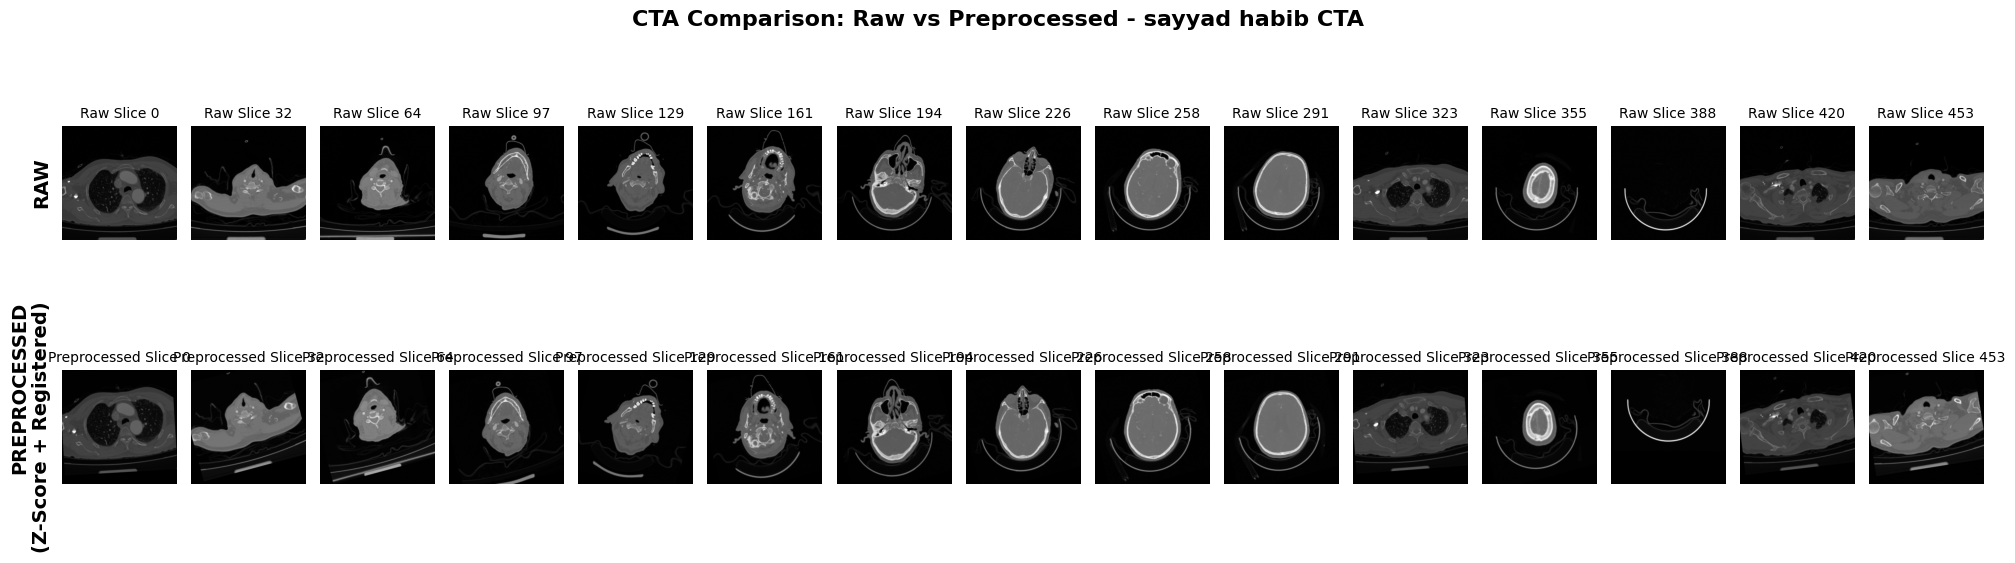


Comparison shows:
- Raw: Original intensity scaling, potential misalignment
- Preprocessed: Z-score standardized, centered, rotation corrected, 256x256


In [25]:
# Visual Comparison: Raw vs Preprocessed
def show_raw_vs_preprocessed_comparison(patient_name, num_slices=12):
    """Show side-by-side comparison of raw vs preprocessed CTA slices"""
    patient_clean = patient_name.replace(" ", "_")
    
    raw_dir = Path("images/cta_raw") / patient_clean
    processed_dir = Path("images/cta_preprocessed") / patient_clean
    
    if not raw_dir.exists() or not processed_dir.exists():
        print(f"Images not found for {patient_name}")
        return
    
    # Get available slices
    raw_files = sorted([f for f in raw_dir.glob("*.png")])
    processed_files = sorted([f for f in processed_dir.glob("*.png")])
    
    if len(raw_files) == 0 or len(processed_files) == 0:
        print(f"No images found for {patient_name}")
        return
    
    # Select evenly spaced slices
    indices = np.linspace(0, len(raw_files)-1, num_slices, dtype=int)
    
    # Create comparison plot
    fig, axes = plt.subplots(2, num_slices, figsize=(20, 6))
    fig.suptitle(f'CTA Comparison: Raw vs Preprocessed - {patient_name}', fontsize=16, fontweight='bold')
    
    for i, idx in enumerate(indices):
        # Load raw image
        raw_img = np.array(Image.open(raw_files[idx]))
        
        # Load preprocessed image
        processed_img = np.array(Image.open(processed_files[idx]))
        
        # Display raw
        axes[0, i].imshow(raw_img, cmap='gray')
        axes[0, i].set_title(f'Raw Slice {idx}', fontsize=10)
        axes[0, i].axis('off')
        
        # Display preprocessed
        axes[1, i].imshow(processed_img, cmap='gray')
        axes[1, i].set_title(f'Preprocessed Slice {idx}', fontsize=10)
        axes[1, i].axis('off')
    
    # Add row labels
    axes[0, 0].text(-0.1, 0.5, 'RAW', transform=axes[0, 0].transAxes, 
                    fontsize=14, fontweight='bold', rotation=90, 
                    verticalalignment='center', horizontalalignment='right')
    
    axes[1, 0].text(-0.1, 0.5, 'PREPROCESSED\n(Z-Score + Registered)', transform=axes[1, 0].transAxes, 
                    fontsize=14, fontweight='bold', rotation=90, 
                    verticalalignment='center', horizontalalignment='right')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nComparison shows:")
    print(f"- Raw: Original intensity scaling, potential misalignment")
    print(f"- Preprocessed: Z-score standardized, centered, rotation corrected, 256x256")

# Show comparison for the first patient
if patients:
    patient_name = patients[0].name
    print(f"Creating visual comparison for: {patient_name}")
    show_raw_vs_preprocessed_comparison(patient_name, num_slices=15)
else:
    print("No patients found for comparison")